In [1]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from copy import deepcopy

import monai
from monai import transforms

from utils.utils import adjust_window, visualize, print_info

Failed to load image Python extension: Could not find module 'D:\Apps\anaconda3\envs\medical\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.


In [2]:
data_dict = {
    'image': '../data/ID_c9d6fdc6_ID_7f09be285d.nii.gz',
    'label': '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.nii.gz'
}

In [3]:
# 数据读取
io_transform = transforms.LoadImaged(keys=["image", "label"])
data = io_transform(data_dict)
print_info(data)

image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


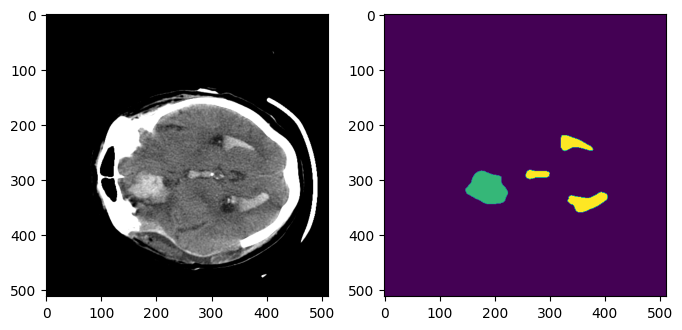

In [4]:
visualize(data)

In [4]:
# 添加channel维度
transform = transforms.EnsureChannelFirstd(keys=["image", "label"])
add_data = transform(data)
print_info(add_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


## RandGaussianNoise

`RandGaussianNoised` 用于在图像中添加**高斯噪声（Gaussian noise）**，并且是**随机施加**的，目的是增强模型的鲁棒性。在输入数据上**以一定概率**添加**高斯噪声**，即：

$$
\text{noisy\_image} = \text{image} + \mathcal{N}(\mu, \sigma^2)
$$

### 使用场景 


- 提高模型对噪声的鲁棒性
- 模拟低质量成像设备或伪影

- 数据增强以缓解过拟合

### 参数解析 

| 参数名                   | 类型                 | 说明                                                         |
| ------------------------ | -------------------- | ------------------------------------------------------------ |
| **`keys`**               | `str` 或 `List[str]` | 要应用该变换的字典键。例如 `["image"]` 表示只对图像添加噪声。 |
| **`prob`**               | `float`              | 应用高斯噪声的概率。值为 0 到 1，默认是 0.1。                |
| **`mean`**               | `float`              | 高斯分布的均值 μ。默认是 0.0。                               |
| **`std`**                | `float`              | 高斯分布的标准差 σ。决定噪声的强度。                         |
| **`dtype`**              | `np.dtype` 或 `None` | 输出的数据类型，默认是 `np.float32`，设置为 `None` 则保持原输入类型。 |
| **`allow_missing_keys`** | `bool`               | 如果为 True，某些指定键缺失时不会报错。常用于不确定所有样本都包含特定键的情况。 |
| **`sample_std`**         | `bool`               | 若设为 `True`，则在 `[0, std]` 范围内**随机采样标准差 σ**，而不是固定使用 `std`。可提升数据多样性。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


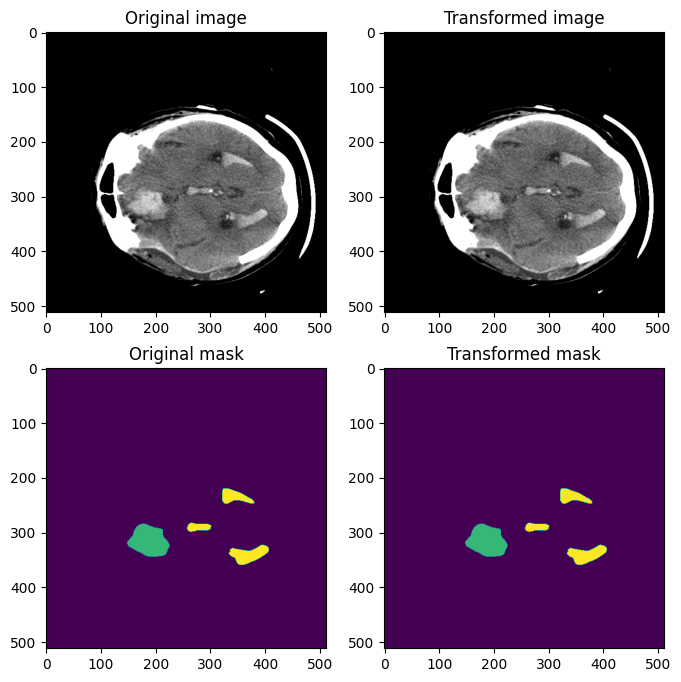

In [6]:
transform = transforms.RandGaussianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandRicianNoise

`RandRicianNoised` 是一种用于医学图像数据增强的随机变换（transform），专门用来向图像中加入Rician噪声。这种噪声在MRI图像中非常常见，用于模拟现实中MRI采集过程中的噪声，帮助模型增强对真实世界数据的鲁棒性。

Rician噪声是复高斯噪声的模长分布，公式为：

$$
I_{\text{rician}} = \sqrt{(I + n_1)^2 + n_2^2}
$$

其中：

-   $I$ 是原始图像像素值

-   $n_1, n_2 \sim \mathcal{N}(0, \sigma^2)$，是两个独立的高斯噪声

### 使用场景 


- 提高模型泛化能力
- 模拟低信噪比（SNR）的图像

- 增强鲁棒性，特别是在多中心或多设备数据集训练中

### 参数解析 

| 参数名               | 类型                | 默认值  | 说明                                                         |
| -------------------- | ------------------- | ------- | ------------------------------------------------------------ |
| keys                 | str 或 list\[str\]  | 必需    | 要添加 Rician 噪声的字段键名，通常为 "image"。               |
| prob                 | float               | 0.1     | 添加 Rician 噪声的概率，范围 \[0, 1\]。                      |
| mean                 | float               | 0.0     | 构造噪声的高斯分布均值。通常设为 0。                         |
| std                  | float               | 0.05    | 高斯分布的标准差，控制噪声强度。                             |
| channel\_wise        | bool                | False   | 若为 True，则对每个通道单独添加噪声。                        |
| relative             | bool                | False   | 若为 True，则 std 表示图像或通道强度标准差的倍数。           |
| sample\_std          | bool                | False   | 若为 True，从区间 \[0, std\] 中随机采样当前样本的 std 值。   |
| dtype                | numpy.dtype 或 None | float32 | 输出图像的数据类型。如果为 None，则保持与输入数据类型一致。  |
| allow\_missing\_keys | bool                | False   | 若为 True，若数据中缺少某个 key 则不会报错。适用于部分字段可能缺失的情况。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


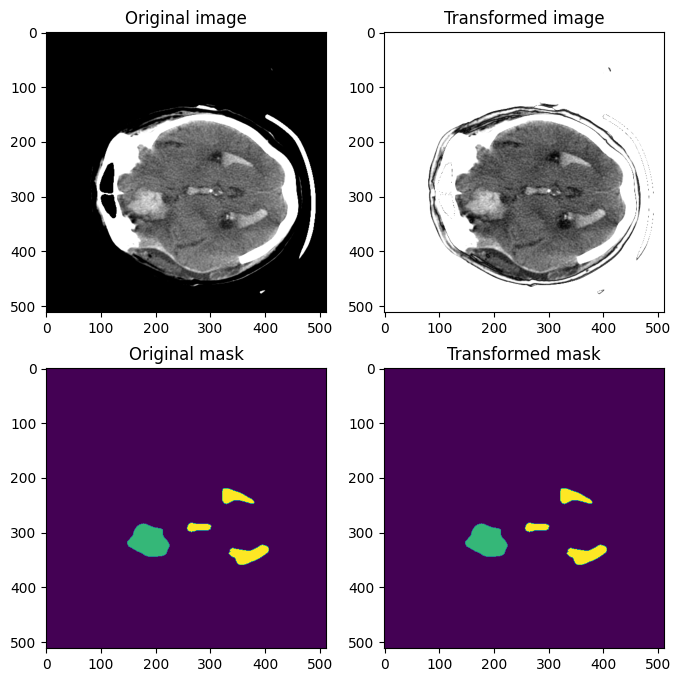

In [7]:
transform = transforms.RandRicianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandShiftIntensity
Rand
`ShiftIntensityd` 用于对图像的像素强度值进行平移（shift）处理。它可以增加训练数据的多样性，提高模型的鲁棒性。该变换作用于图像像素值，将其加上一个偏移值，使图像亮度发生变化。

### 使用场景 

-   用于模拟不同成像条件下的亮度变化。

-   增强模型对于亮度/对比度变化的适应能力。

-   特别适用于 MRI、CT 等灰度图像。

### 参数解析 

| 参数名               | 类型                           | 默认值       | 说明                                                         |
| -------------------- | ------------------------------ | ------------ | ------------------------------------------------------------ |
| keys                 | str 或 Sequence\[str\]         | 无           | 指定要应用变换的数据字段名称，常用为 "
| prob                 | float               | 0.1     | 添加 Rician 噪声的概率，范围 \[0, 1\]。                      |image"，支持多个字段。 |
| offset               | float 或 Tuple\[float, float\] | 无           | 强度偏移值；如果为范围 (a, b)，则每次变换随机从该区间采样一个值并加到图像像素上。 |
| safe                 | bool                           | False        | 是否在像素值溢出时进行安全裁剪。例如当数据类型为 uint8 时，255+1 结果会变为 255，而不是溢出成 0。 |
| factor\_key          | str 或 Sequence\[str\]         | None         | 若提供该参数，则 offset 会乘以从 metadata 中提取的 factor 值（如图像均值），以实现动态强度平移。通常和 IntensityStatsd 搭配使用。 |
| meta\_keys           | str 或 Sequence\[str\]         | None         | 显式指定用于提取 factor\_key 的 metadata 字典键（如 "image\_meta\_dict"）。若不指定，会由 key 和 meta\_key\_postfix 拼接得出。 |
| meta\_key\_postfix   | str                            | "meta\_dict" | 若未设置 meta\_keys，将使用 key + meta\_key\_postfix 构造 metadata 的键名（如 "image" ⇒ "image\_meta\_dict"）。 |
| allow\_missing\_keys | bool                           | False        | 若为 True，则当指定的 key 不存在时不会抛出异常。适用于处理不规则数据批次或多输入结构。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


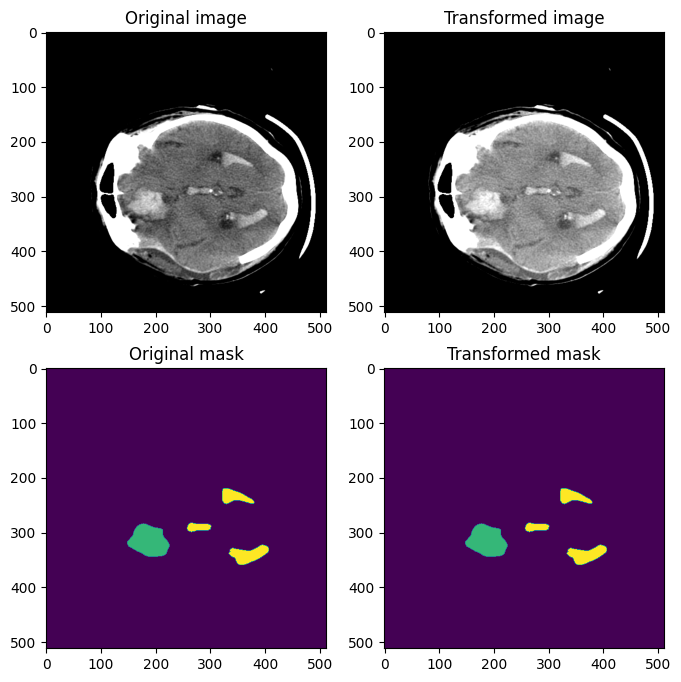

In [8]:
 transform = transforms.RandShiftIntensityd(
     keys=["image"],
     offsets=[10, 20],
     prob=1
 )
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandStdShiftIntensity

`RandStdShiftIntensityd` 用于改变图像的强度值（intensity），特别适合医学图像处理中做亮度/对比度扰动，增加模型的鲁棒性。

### 使用场景 

-   用于模拟不同成像条件下的亮度变化。

-   增强模型对于亮度/对比度变化的适应能力。

-   特别适用于 MRI、CT 等灰度图像。

### 参数解析 

| 参数名               | 说明                                                         | 备注                                |
| -------------------- | ------------------------------------------------------------ | ----------------------------------- |
| `keys`               | 要变换的字典键（key），指定应用变换的字段名称                | 例如 `["image"]`                    |
| `factors`            | 控制扰动幅度。若是元组，随机选取范围 `(min(factors), max(factors))`； | 用于乘以图像的标准差，生成偏移量    |
| `prob`               | 变换应用概率，范围 `[0,1]`                                   | 如 `0.1` 表示 10% 概率应用          |
| `nonzero`            | 是否只基于非零像素计算标准差                                 | `True` 时忽略零值（背景）像素       |
| `channel_wise`       | 是否对每个通道单独计算标准差                                 | `True` 时每通道分别扰动             |
| `dtype`              | 输出数据类型                                                 | 默认 `float32`；`None` 保持输入类型 |
| `allow_missing_keys` | 是否允许字典中缺失指定的 keys 而不抛异常                     | 防止因缺键导致程序崩溃              |

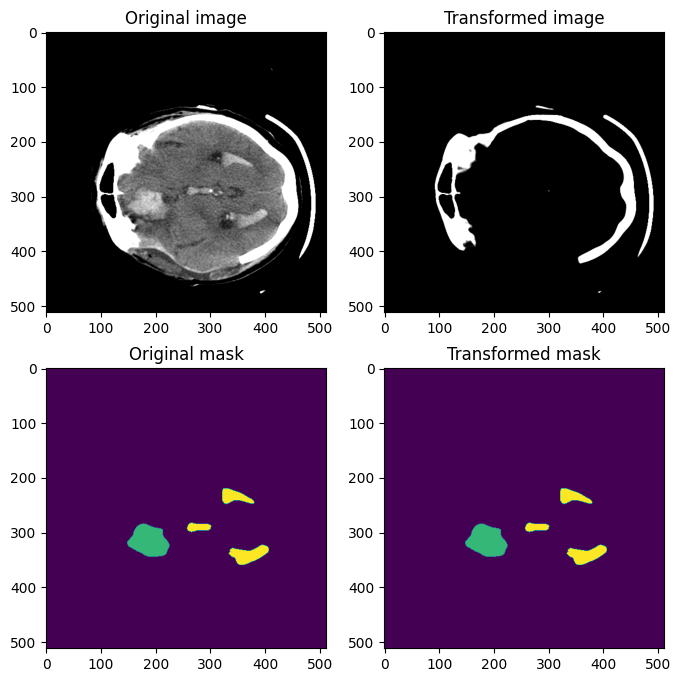

In [25]:
transform = transforms.RandStdShiftIntensityd(
    keys="image", 
    factors=0.2, 
    prob=1
)
add_data_tmp = deepcopy(add_data)
aug_data = transform(add_data_tmp)
visualize(data, aug_data)

## RandScaleIntensity

 `RandScaleIntensityd` 用于医学图像的强度归一化和增强，提升模型对图像亮度或对比度变化的鲁棒性。

### 使用场景 

-   用于模拟不同成像条件下的亮度变化。

-   增强模型对于亮度/对比度变化的适应能力。

-   特别适用于 MRI、CT 等灰度图像。

### 参数解析 

| 参数名               | 类型             | 默认值            | 说明                                                         |
| -------------------- | ---------------- | ----------------- | ------------------------------------------------------------ |
| `keys`               | list of str      | 必填              | 需要被变换的字典键名列表，如 `"image"`。                     |
| `factors`            | float 或 tuple   | (0.9, 1.1) 或单数 | 缩放因子的范围，变换计算为 `v = v * (1 + factor)`。单数时从 (-factors, factors) 采样。 |
| `prob`               | float            | 0.1               | 执行缩放变换的概率。10% 的概率应用。                         |
| `channel_wise`       | bool             | False             | 是否对每个通道分别随机缩放。需要保证输入图像第一个维度是通道。 |
| `dtype`              | 数据类型 或 None | float32           | 输出图像的数据类型。默认转为 `float32`。                     |
| `allow_missing_keys` | bool             | False             | 当字典中缺少指定键时，是否忽略并跳过，而非抛出异常。         |

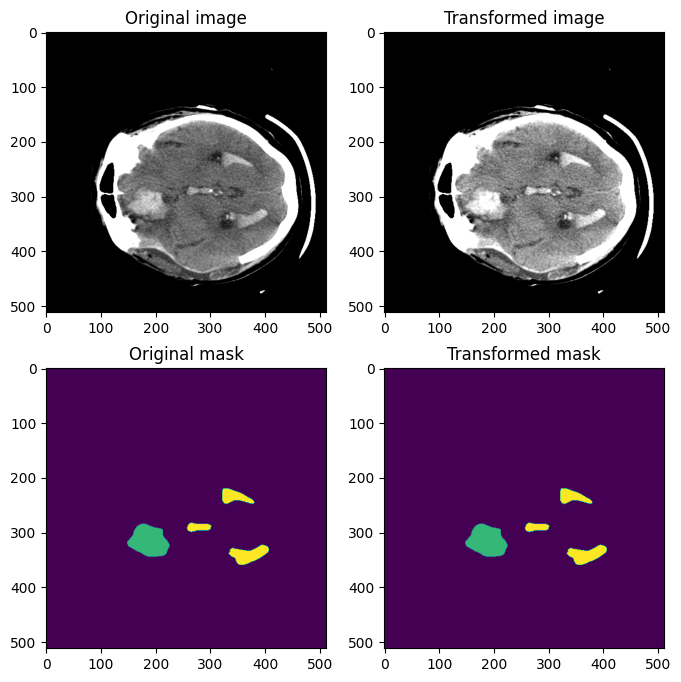

In [11]:
# v = v * (1 + factor)
transform = transforms.RandScaleIntensityd(
    keys="image", 
    factors=(0.3, 0.5), 
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandScaleIntensityFixedMean

`RandScaleIntensityFixedMeand`作用是对输入图像的像素值进行随机尺度缩放，但保持图像的均值固定，从而模拟不同的图像强度分布，增加模型的鲁棒性。

### 使用场景 

-   医学图像训练中模拟图像强度的随机变化，但保持图像整体亮度一致，防止模型过拟合于特定强度分布。

-   数据集图像亮度均值差异不大时，适用此变换以增加数据多样性。

-   适合CT、MRI等灰度图像的预处理。

### 参数解析 

| 参数名               | 类型              | 说明                                                         | 默认值 / 备注   |
| -------------------- | ----------------- | ------------------------------------------------------------ | --------------- |
| `keys`               | List\[str\]       | 需要变换的字典键名，指定要变换的图像数据字段              
| `prob`               | float            | 0.1。执行缩放变换的概率。10% 的概率应用。              | 0.1                         |   | 无，必须指定    |
| `factors`            | float or tuple    | 缩放因子范围，采样的`factor`用于计算变换：`v = v * (1 + factor)`，若为单个数字，则采样范围为`(-factors, factors)` | 无，必须指定    |
| `preserve_range`     | bool              | 是否将输出裁剪回输入的数值范围，防止数值溢出                 | `False`         |
| `fixed_mean`         | bool              | 是否保持图像均值不变：先减均值，再缩放，最后加回均值         | `True`          |
| `channel_wise`       | bool              | 是否对每个通道单独缩放和保持均值，适用于多通道图像           | `False`         |
| `dtype`              | torch.dtype或None | 输出数据类型，默认`float32`，`None`表示保持输入类型          | `torch.float32` |
| `allow_missing_keys` | bool              | 是否允许输入字典中缺少指定`keys`时不报错                     | `False`         |

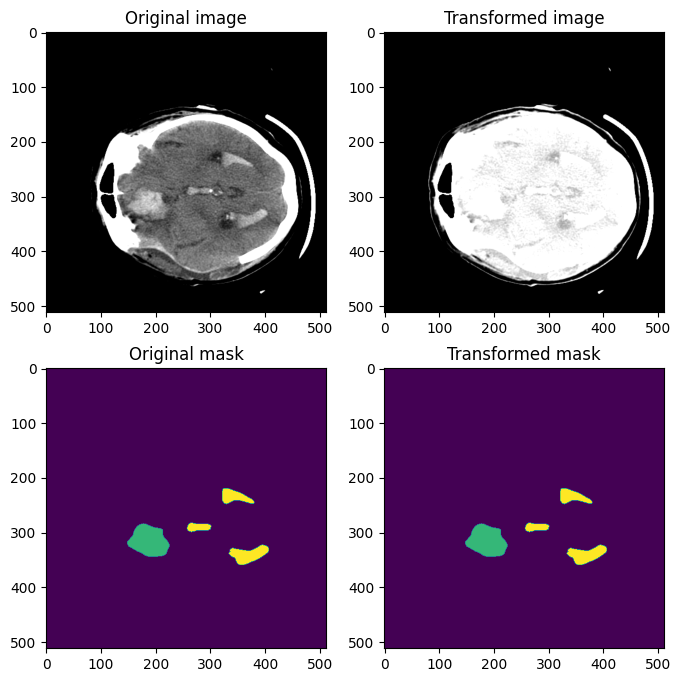

In [26]:
# v = v - mean(v)
# v = v * (1 + factor) + mean(v)
transform = transforms.RandScaleIntensityFixedMeand(
    keys="image",
    factors=0.2,
    fixed_mean=True,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandBiasField

`RandBiasFieldd` 主要模拟MRI图像中常见的偏场效应（bias field），即图像亮度非均匀性的伪影。通过随机生成一个低频的乘性场（bias field）叠加到图像上，可以增加模型对实际图像中亮度不均匀情况的鲁棒性。

### 使用场景 

-   给输入的图像增加随机生成的偏场伪影，从而模拟真实MRI中亮度非均匀性。

### 参数解析 

| 参数名        | 含义                                                         | 默认值       |
| ------------- | ------------------------------------------------------------ | ------------ |
| `keys`        | 要进行增强的字段名称列表，通常是图像的key                    | `["image"]`  |
| `coeff_range` | 多项式系数的取值范围，决定偏场的强度和形态，长度3的tuple，如 `(0.1, 0.5)` | `(0.1, 0.5)` |
| `order`       | 多项式拟合的阶数，默认为3，阶数越高偏场越复杂                | `3`          |
| `mode`        | 插值方式，通常使用 `"bilinear"`                              | `"bilinear"` |
| `prob`        | 该变换被应用的概率                                           | `0.1`        |
| `device`      | 计算设备，如`"cpu"`或`"cuda"`                                | `None`       |



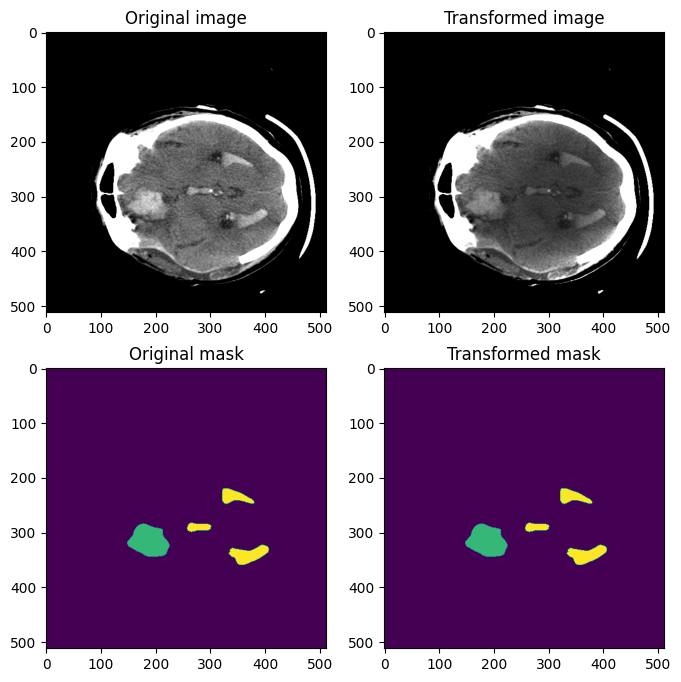

In [28]:
transform = transforms.RandBiasFieldd(
    keys="image",
    degree=3,
    coeff_range=(0.7, 1),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## NormalizeIntensity

`NormalizeIntensityd` 是一种常用的基于字典的变换（dictionary-based transform），主要用于对图像数据进行强度归一化处理。

### 使用场景 

-   归一化后的图像数据能帮助深度学习模型更快收敛，减少强度值范围差异带来的影响。

### 参数解析 

| 参数名               | 说明                                                         | 默认值             |
| -------------------- | ------------------------------------------------------------ | ------------------ |
| `keys`               | 需要进行变换的字典键名列表，指定要归一化的图像字段。参考 `monai.transforms.MapTransform` | 必填               |
| `subtrahend`         | 减去的数值，通常是均值，用于归一化前减去该值                 | 无（默认自动计算） |
| `divisor`            | 除以的数值，通常是标准差，用于归一化时除以该值               | 无（默认自动计算） |
| `nonzero`            | 是否只对非零值进行归一化，常用于忽略背景0的像素              | False              |
| `channel_wise`       | 是否对每个通道单独计算均值和标准差，True则分通道计算，False则整体计算 | False              |
| `dtype`              | 输出数据类型，如果为 None，则和输入数据类型相同；默认转换为 `float32` | `float32`          |
| `allow_missing_keys` | 如果指定的 key 不存在，是否允许跳过该 key 不抛出异常         | False              |

image mean: -0.00, image std: 1.00


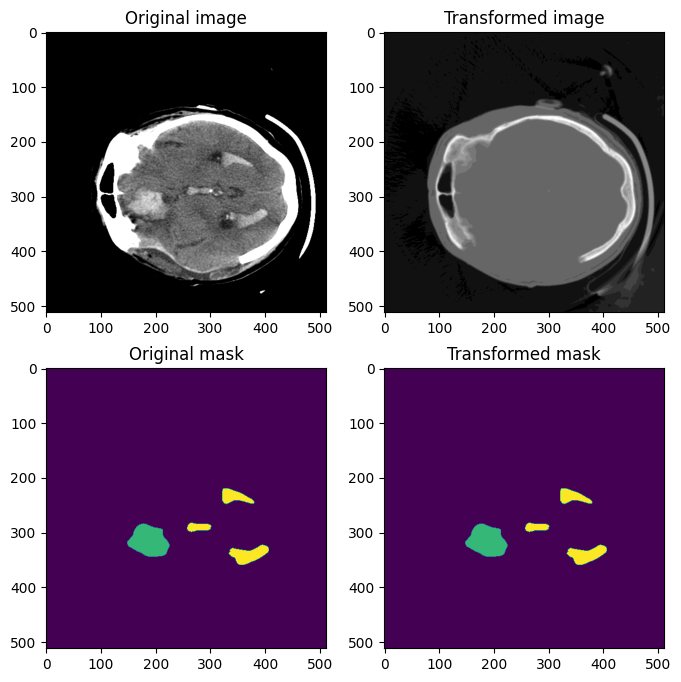

In [31]:
transform = transforms.NormalizeIntensityd(
    keys="image"
)
aug_data = transform(add_data)
print(f"image mean: {aug_data['image'].mean():.2f}, image std: {aug_data['image'].std():.2f}")
visualize(data, aug_data)

## ThresholdIntensity

`ThresholdIntensityd` 用于医学图像处理任务中对图像进行**阈值化操作**。它主要用于将图像中小于或大于某个值的像素设置为一个特定值。这个操作在医学图像中非常常见，比如屏蔽掉背景噪声、保留特定强度范围的结构等。

### 使用场景 

-   **抑制背景噪声**：医学图像通常存在背景伪影，可以通过阈值化去除；
-   **增强前景**：比如想只保留 CT 或 MRI 中的高密度区域（例如骨骼、肿瘤）；
-   **用于下游二值化处理**：如前景/背景分类、图像分割预处理等。

### 参数解析 

| 参数        | 类型        | 说明                                                         |
| ----------- | ----------- | ------------------------------------------------------------ |
| `keys`      | str 或 list | 要处理的字段名（如 `"image"`）                               |
| `threshold` | float       | 阈值，默认是 `0.0`                                           |
| `above`     | bool        | 如果为 `True`，则保留 `>= threshold` 的像素，其它设为 `cval`；如果为 `False`，则保留 `< threshold` 的像素 |
| `cval`      | float       | 被屏蔽像素设置的值，默认是 `0.0`                             |

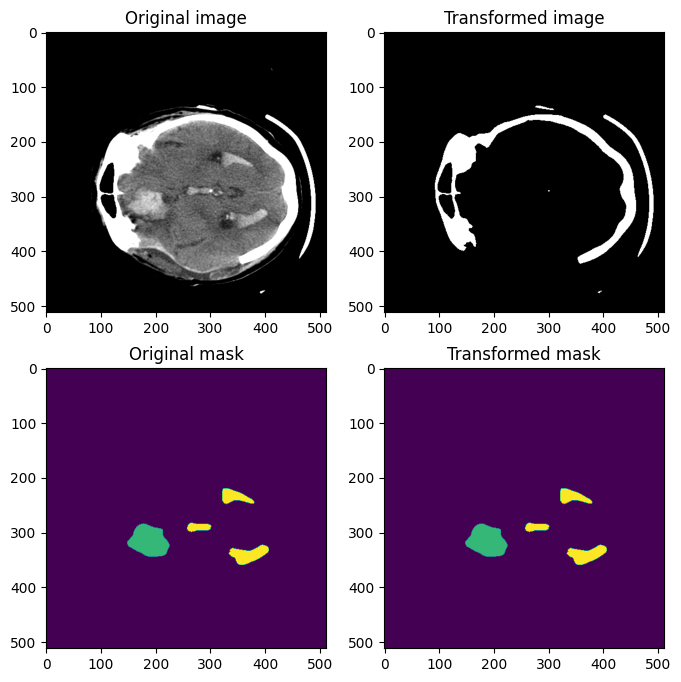

In [7]:
transform = transforms.ThresholdIntensityd(
    keys="image",
    threshold=100,
    above=True,
    cval=0
)
aug_data = transform(add_data)
visualize(data, aug_data)

## ScaleIntensityRange

`ScaleIntensityRanged` 作用是对图像的强度值进行线性缩放（归一化），将图像中某个强度范围 `[a_min, a_max]` 线性映射到 `[b_min, b_max]`。

### 使用场景 

-   **CT 图像**：HU 范围 \[-1000, 1000\]，常选取子范围如 \[-100, 400\] 映射到 \[0, 1\]。
-   **MRI 图像**：强度不固定，通常根据数据统计结果设定 `a_min`, `a_max`。
-   深度学习模型训练前的标准化步骤。

### 参数解析 

| 参数名  | 解释                                                         |
| ------- | ------------------------------------------------------------ |
| `keys`  | 字符串或字符串列表，表示要处理的图像字段。比如：`"image"`    |
| `a_min` | 原图像强度的最小值（输入范围的下限）                         |
| `a_max` | 原图像强度的最大值（输入范围的上限）                         |
| `b_min` | 要映射到的最小值（输出范围的下限）                           |
| `b_max` | 要映射到的最大值（输出范围的上限）                           |
| `clip`  | 是否将原始值裁剪到 `[a_min, a_max]`。如果为 `True`，则超过范围的值会被截断；否则将被线性映射但不会裁剪。 |

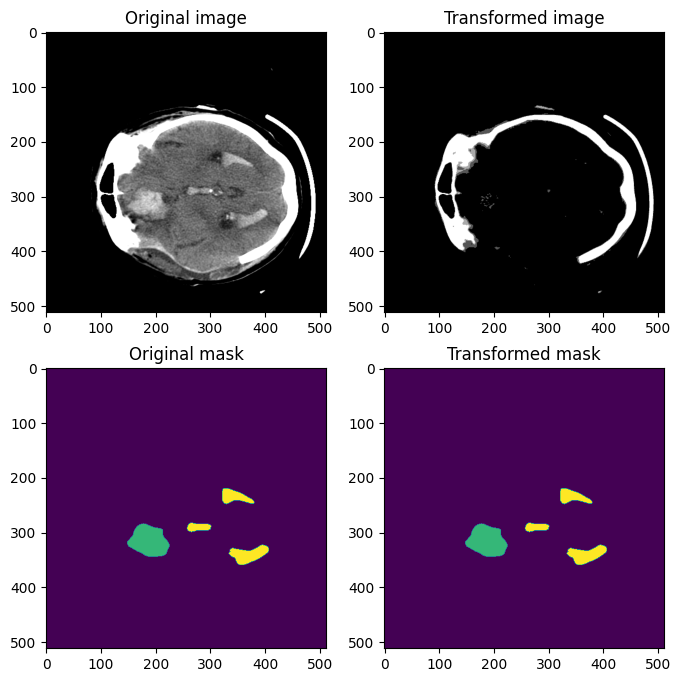

In [9]:
transform = transforms.ScaleIntensityRanged(
    keys=["image"],
    a_min=0,
    a_max=255,
    b_min=0.0,
    b_max=1.0,
    clip=True
)
aug_data = transform(add_data)
visualize(data, aug_data)

## ClipIntensityPercentiles

`ClipIntensityPercentilesd` 作用是**根据指定的百分位数剪裁图像的强度值**，从而抑制图像中的极端值（如高亮点或背景噪声）对模型训练的影响。

`ClipIntensityPercentilesd` 主要功能是：

-   计算图像中非零区域的某两个百分位数（例如 0.5% 和 99.5%）；

-   然后将图像像素值限制在这个范围内；

-   超出范围的值被截断（clip）到对应边界值。

### 使用场景 

-   CT/MRI 图像预处理；

-   图像强度值范围较大且含有异常值；

-   模型训练前对输入数据标准化处理；

### 参数解析 

| 参数             | 类型                 | 说明                                                         |
| ---------------- | -------------------- | ------------------------------------------------------------ |
| `keys`           | `str` 或 `list[str]` | 需要应用该变换的图像字段名（如 `"image"`）。                 |
| `lower`          | `float`              | 下百分位阈值，默认 `0.1`，即 0.1%。                          |
| `upper`          | `float`              | 上百分位阈值，默认 `99.9`，即 99.9%。                        |
| `channel_wise`   | `bool`               | 是否按通道分别计算百分位。常用于多通道 MRI/CT 图像，默认为 False。 |
| `relative`       | `bool`               | 是否将 `lower` 和 `upper` 作为相对值（相对于 `min_percentile` 和 `max_percentile`）。 |
| `min_percentile` | `float`              | 百分位范围最小值限制。                                       |
| `max_percentile` | `float`              | 百分位范围最大值限制。                                       |

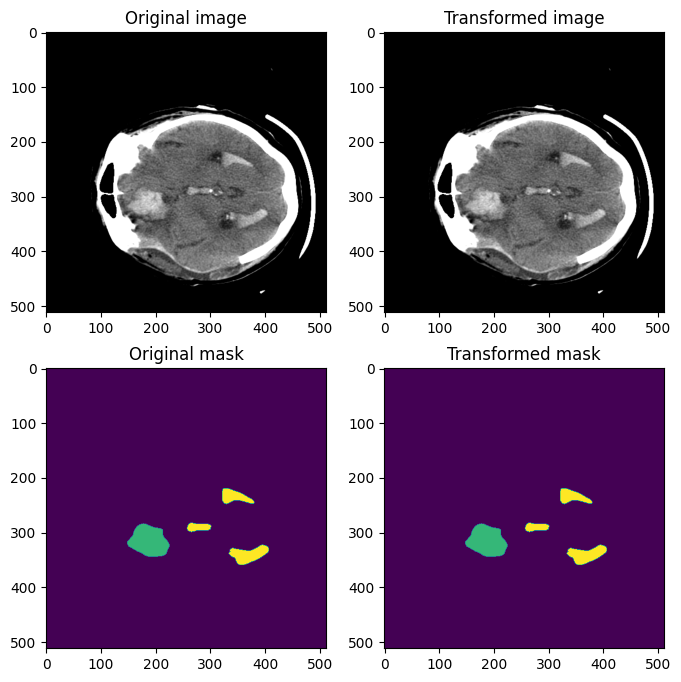

In [10]:
# 对图像强度值按通道在 0.5% ~ 99.5% 之间截断
transform = transforms.ClipIntensityPercentilesd(
    keys=["image"],
    lower=0.5,
    upper=99.5,
    channel_wise=True
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandAdjustContrast

`monai.transformRands.AdjustContrastd` 用于调整图像的对比度。这个变换对于医学图像处理特别有用，比如增强图像中不同组织之间的对比度，从而帮助模型更好地识别结构。

这个对比度增强的基本原理是根据图像的均值来重新分布像素值：

`x = ((x - min) / intensity_range) ^ gamma * intensity_range + min`

-   如果 `gamma > 1`，图像的对比度增强（更亮或更暗的区域更加显著）

-   如果 `gamma < 1`，图像的对比度减弱（更趋向于灰色）

### 使用场景 

-   对于低动态范围的图像（比如本身对比度低的 CT），调整对比度可能带来更多可见特征
-   太高的 `gamma` 可能导致图像过曝或信息丢失；

### 参数解析 

| 参数名               | 类型                 | 说明                                                         |
| -------------------- | -------------------- | ------------------------------------------------------------ |
| `keys`               | `str` 或 `list[str]` | 需要应用该变换的字典键名，参考 `MapTransf
| `prob`               | float                | 执行缩放变换的概率。                         |orm`                |
| `gamma`              | `float`              | Gamma 值，用于控制对比度调整函数的强度                       |
| `invert_image`       | `bool`               | 是否在应用 gamma 变换前后反转图像（乘以 -1）                 |
| `retain_stats`       | `bool`               | 是否在 gamma 变换后保留原始图像的均值和标准差（通过线性变换恢复）； |
| `allow_missing_keys` | `bool`               | 如果为 True，则在某些键缺失时不抛出异常                      |

intensity range: 63859.0


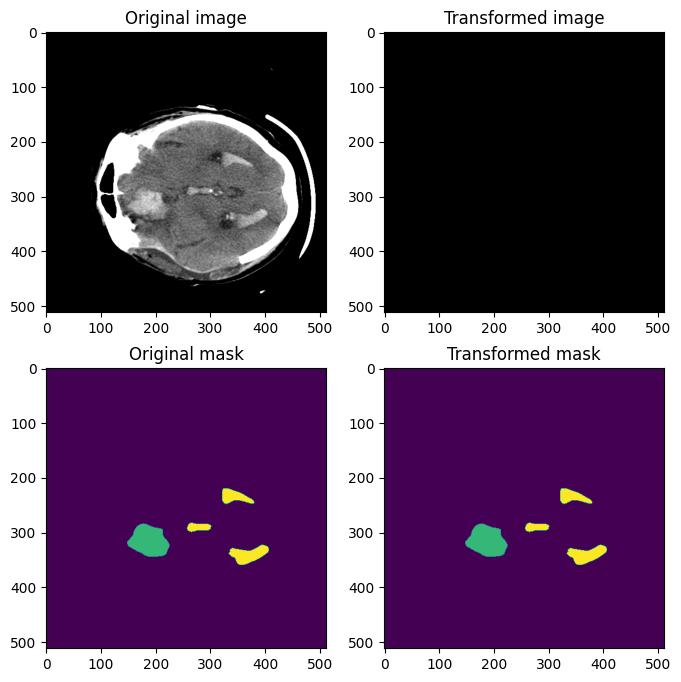

In [13]:
transform = transforms.RandAdjustContrastd(
    keys="image",
    prob=1,
    gamma=1.1
)
aug_data = transform(add_data)
print(f"intensity range: {data['image'].max() - data['image'].min()}")
visualize(data, aug_data)

## ScaleIntensityRangePercentiles

`monai.transforms.ScaleIntensityRangePercentilesd`用于根据图像强度的 **百分位数（percentiles）** 重新缩放图像的强度值。

原始图像中某些强度值可能是异常值（噪声、伪影等），直接用最小最大值缩放容易受这些极端值影响。

本变换使用百分位数来决定缩放范围。例如：

-   使用第 0.5 百分位和第 99.5 百分位估算强度范围，可以有效去除极端值影响。

-   然后把这个范围线性映射到新的范围（默认是 `[0.0, 1.0]`）。

### 使用场景 

-   医学图像（如 MRI、CT）中强度值不统一或有极端值时进行标准化。

-   在训练前对图像进行统一强度预处理，提高模型稳定性。

-   适用于需要保留原始结构但抑制噪声和伪影的场景。

### 参数解析 

| 参数    | 说明                                                         |
| ------- | ------------------------------------------------------------ |
| `keys`  | 要处理的键名，通常是 `"image"`。                             |
| `lower` | 原始图像强度范围的下百分位（如 0.5）。                       |
| `upper` | 原始图像强度范围的上百分位（如 99.5）。                      |
| `b_min` | 缩放后的目标最小值（如 0.0）。                               |
| `b_max` | 缩放后的目标最大值（如 1.0）。                               |
| `clip`  | 如果为 True，则将输出裁剪在 `[b_min, b_max]` 范围内，防止溢出。 |

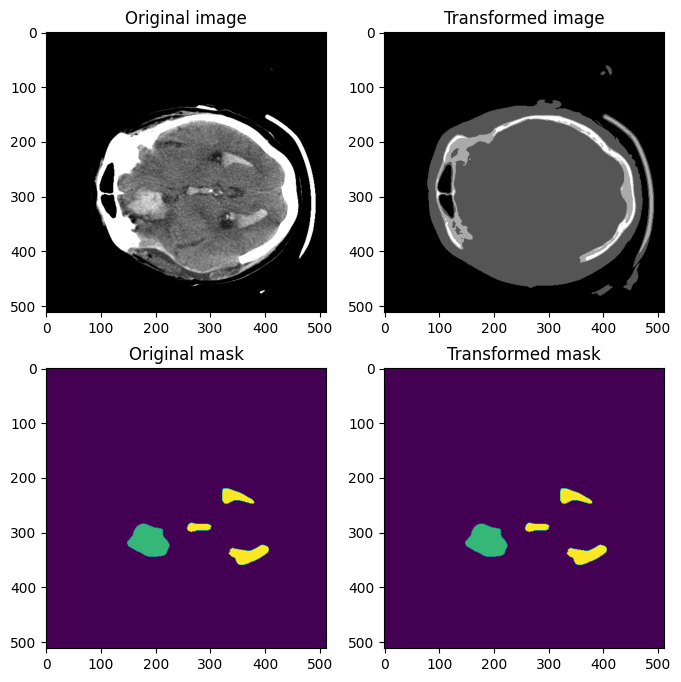

In [14]:
transform = transforms.ScaleIntensityRangePercentilesd(
    keys=["image"],
    lower=0.5, 
    upper=99.5,
    b_min=0.0, 
    b_max=1.0,
    clip=True
)
aug_data = transform(add_data)
visualize(data, aug_data)

## MaskIntensity

`MaskIntensityd`用于根据掩码（mask）来调整图像的强度。这个操作常用于医学图像处理任务，比如在训练神经网络之前对图像进行预处理，使模型能更关注掩码区域内的有效信息。**仅对掩码所定义的区域进行强度变换（通常是归一化或标准化）**，而忽略其他区域的像素值。



### 使用场景 

-   在病灶检测中，仅对病灶区域进行标准化处理；

-   在脑部 MRI 分割中，只对大脑区域进行强度归一化，忽略头骨等背景部分；

-   降低背景区域对模型训练的干扰，提高网络对前景的敏感度。

### 参数解析 

| 参数名               | 类型                                     | 说明                                                         |
| -------------------- | ---------------------------------------- | ------------------------------------------------------------ |
| `keys`               | `str` 或 `Sequence[str]`                 | 需要进行强度遮罩处理的图像数据字段名。参见 `MapTransform` 中的用法。 |
| `mask_data`          | `torch.Tensor` 或 `np.ndarray` 或 `None` | 掩码数据：若为单通道，则对图像每个通道重复使用；若为多通道，则通道数必须与输入图像一致；被选中的掩码值对应的图像像素保持原值，其余设为0；若为 `None`，则通过 `mask_key` 从数据字典中提取。 |
| `mask_key`           | `str`                                    | 用于从输入字典中提取掩码数据的键名，仅在 `mask_data` 为 `None` 时有效。 |
| `select_fn`          | `Callable`                               | 用于从掩码数据中选择有效值的函数，默认选择 `mask > 0` 的区域。可以自定义条件。 |
| `allow_missing_keys` | `bool`                                   | 若为 True，当某个 key 缺失时不会抛出异常（容错处理）。       |

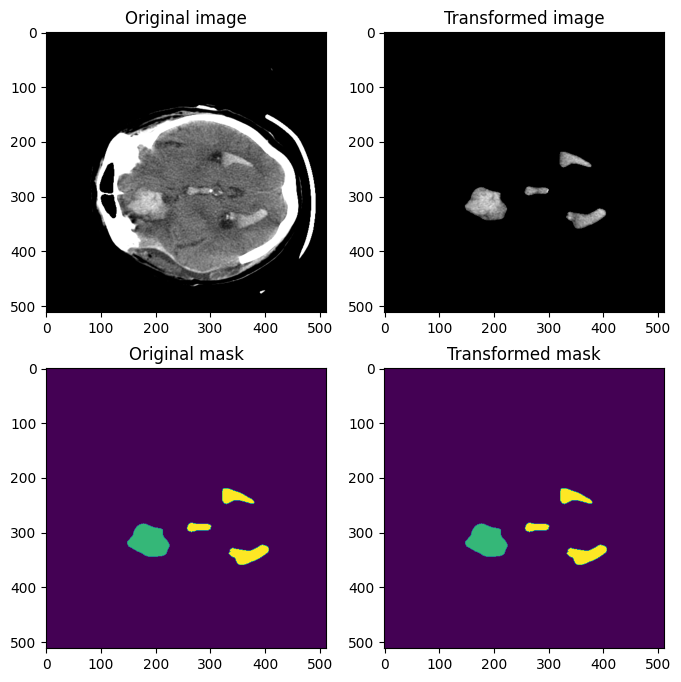

In [15]:
transform = transforms.MaskIntensityd(
    keys="image",
    # mask_data=add_data["image"] - 20
    mask_key="label"
)
aug_data = transform(add_data)
visualize(data, aug_data)

## SavitzkyGolaySmooth

`SavitzkyGolaySmoothd` 用于对医学图像或信号数据做 **Savitzky-Golay滤波平滑**，以去噪并平滑数据，同时尽可能保留信号的特征（如峰值形状）。**Savitzky-Golay 滤波器**是一种数字滤波器，用于平滑数据。它通过对数据点局部窗口内拟合一个多项式，然后用这个多项式值替换窗口中心点，从而减少噪声，但能较好保留信号的形态细节，比如峰和波谷。

### 使用场景 

-   适用于对 1D 信号或时间序列数据做平滑处理。

-   在医学图像分析中，常用于平滑时间序列、光谱、放射学信号等。

-   通过平滑减少噪声，提高模型训练的信号质量。

### 参数解析 

| 参数名               | 说明                                                         | 类型        | 默认值    | 备注                                                         |
| -------------------- | ------------------------------------------------------------ | ----------- | --------- | ------------------------------------------------------------ |
| `keys`               | 需要转换的字典中对应的key                                    | list 或 str | 必须指定  | 继承自 `MapTransform`，指定作用的字段                        |
| `window_length`      | 滤波窗口长度，必须是正的奇数                                 | int         | 无        | 滤波窗口大小，影响平滑效果。窗口长度越大，平滑效果越强，但细节丢失越多。一般根据采样频率和信号特性调节 |
| `order`              | 多项式拟合阶数，必须小于 `window_length`                     | int         | 无        | 多项式拟合阶数，控制平滑细节。拟合多项式阶数，阶数越高，拟合越复杂，可以更好捕捉复杂曲线，但过高容易过拟合噪声。 |
| `axis`               | 应用滤波的轴，默认是第1个空间维度                            | int         | 1         | 常用于指定时间或空间轴                                       |
| `mode`               | 填充模式，传递给卷积类，支持 `'zeros'`、`'reflect'`、`'replicate'`、`'circular'` | str         | `'zeros'` | 边界处理方式，类似于 `torch.nn.Conv1d` 的padding模式         |
| `allow_missing_keys` | 如果字典中缺失指定key，不抛异常                              | bool        | False     | 是否允许缺少指定key，默认不允许                              |



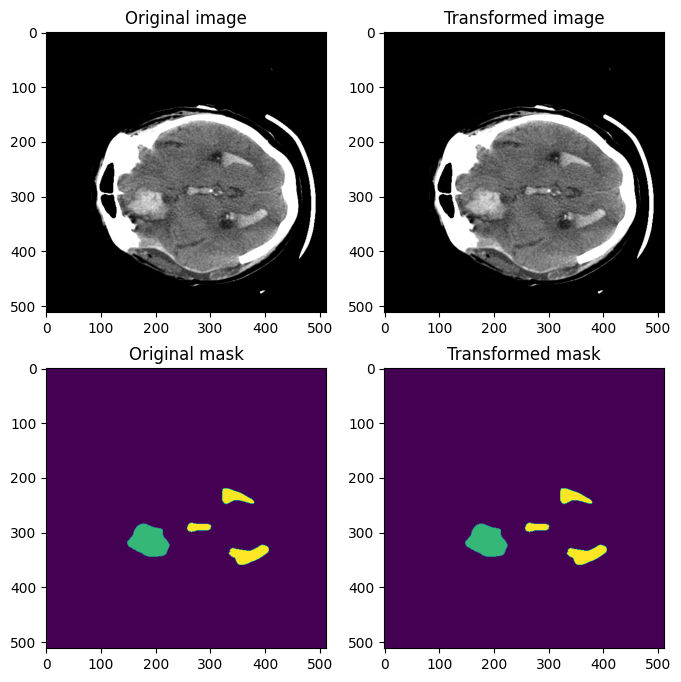

In [16]:
transform = transforms.SavitzkyGolaySmoothd(
    keys="image",
    window_length=7,
    order=4
)
aug_data = transform(add_data)
visualize(data, aug_data)

## MedianSmooth

`MedianSmoothd一，用于对医疗图像数据进行**中值平滑（Median Smoothing）**处理。这种变换通常用于去噪，保留图像边缘信息，是一种经典的图像滤波方式。

### 使用场景 

-   **噪声抑制**：对 MRI、CT 图像去除椒盐噪声或随机噪声。

-   **预处理**：增强图像平滑性，提高后续模型训练稳定性。

-   **边缘保留**：相比均值滤波，中值滤波更能保留图像边缘信息，适合医学图像结构分析。

### 参数解析 

| 参数名               | 类型                        | 说明                                                         |
| -------------------- | --------------------------- | ------------------------------------------------------------ |
| `keys`               | `Sequence[str]`             | 要进行中值滤波变换的字典键名。通常为 `["image"]` 或 `["image", "label"]`。详见 `MapTransform` 的用法。 |
| `radius`             | `Union[int, Sequence[int]]` | 中值滤波的半径。若为单个数值，则在所有空间维度上使用相同的值；若为列表，其长度必须与输入数据的空间维度数相同，每个值分别对应一个维度。实际 kernel size = `2 * radius + 1`。 |
| `allow_missing_keys` | `bool`                      | 如果为 `True`，当字典中缺少指定的 `key` 时将不会报错，而是跳过处理。默认值为 `False`。 |

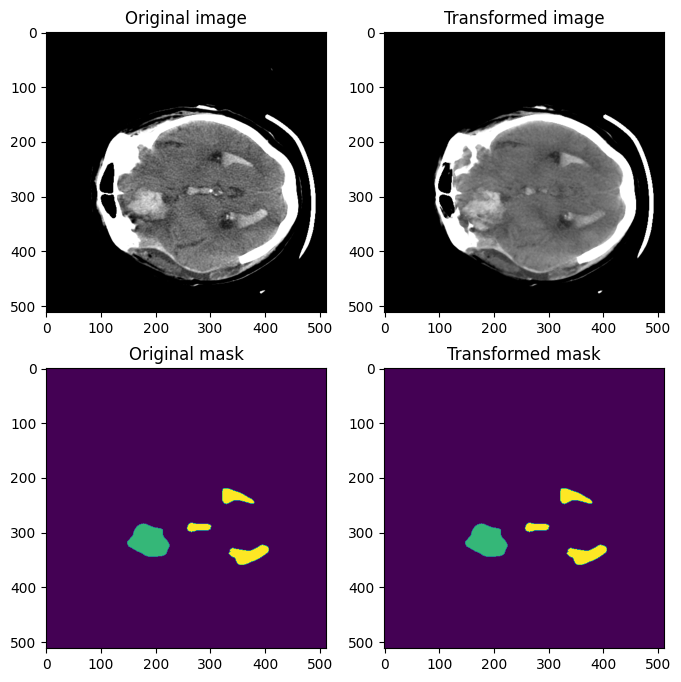

In [17]:
transform = transforms.MedianSmoothd(
    keys="image",
    radius=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandGaussianSmooth

`RandGaussianSmoothd` 作用是**以一定概率对输入图像应用高斯平滑**（Gaussian smoothing），可以模拟模糊或降低图像清晰度，增强模型的鲁棒性。

### 使用场景 

-   增强模型对**图像模糊**、**低对比度**或**分辨率变化**的鲁棒性；

-   避免模型过度拟合于清晰图像特征；

-   在训练数据中引入“图像模糊”作为一种常见变异，提升模型泛化能力。

### 参数解析 

| 参数名               | 类型            | 说明                                                         |
| -------------------- | --------------- | ------------------------------------------------------------ |
| `keys`               | `Sequence[str]` | 要应用高斯平滑的字段名称（如 `"image"` 等）。参见 `MapTransform`。 |
| `sigma_x`            | `float tuple`   | `sigma` 值越大，图像越模糊                                   |
| `sigma_y`            | `float tuple`   | `sigma` 值越大，图像越模糊                                   |
| `sigma_z`            | `float tuple`   | `sigma` 值越大，图像越模糊                                   |
| `approx`             | `str`           | 使用的离散高斯核近似方法，可选值：`"erf"`、`"sampled"`、`"scalespace"`。参见 `GaussianFilter`。 |
| `prob`               | `float`         | 应用该变换的概率（0~1）。                                    |
| `allow_missing_keys` | `bool`          | 若为 True，当字典中缺少指定键时不抛出异常。                  |

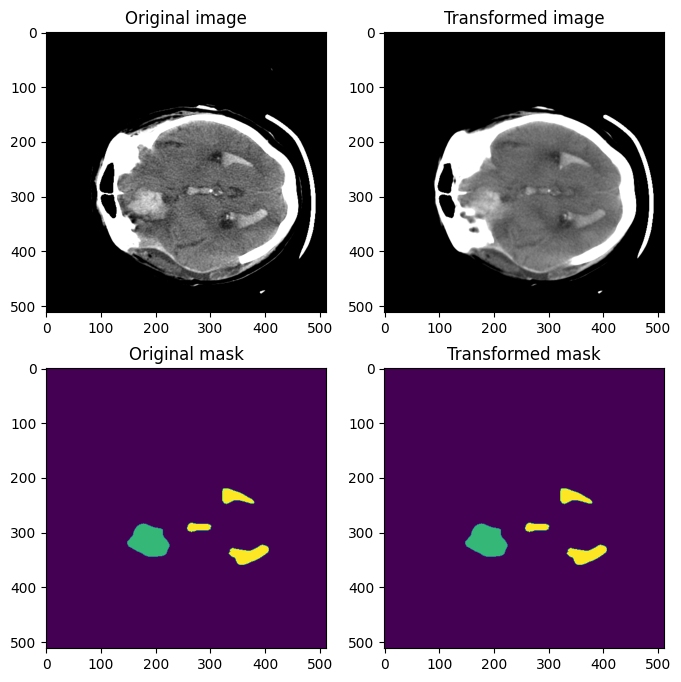

In [5]:
transform = transforms.RandGaussianSmoothd(
    keys="image",
    sigma_x=(0.25, 1.25),
    sigma_y=(0.25, 1.25),
    sigma_z=(0.25, 1.25),
    prob=1,
    approx="erf"   # erf sampled scalespace
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandGaussianSharpen

`RandGaussianSharpen`属于图像锐化的一种方式，通过添加高频信息提升图像清晰度。它是随机应用的高斯锐化，用于增强训练数据的多样性，有助于提升模型的泛化能力。

锐化变换的一般原理如下：

```text
sharpened = original + alpha * (gaussian_blur1 - gaussian_blur2)
```

1.  **原图像**：输入图像。

2.  **模糊图1**（σ1）：通过第一个高斯滤波器平滑图像。

3.  **模糊图2**（σ2）：通过另一个不同σ的高斯滤波器再次平滑图像。

4.  **增强细节**：计算两者差值 `(blur1 - blur2)` 得到细节信息。

5.  **加权组合**：通过 `alpha` 控制锐化程度，并将其加回原图中。

### 使用场景 

-   建议在图像对比度较低或边缘模糊的医学图像中使用。

-   不要设置 `prob` 太高，否则可能导致数据分布失真。

### 参数解析 

| 参数名               | 类型                             | 说明                                                         |
| -------------------- | -------------------------------- | ------------------------------------------------------------ |
| `keys`               | `Sequence[str]`                  | 要应用变换的字典键（例如 `"image"`、`"label"` 等）。参考 `MapTransform`。 |
| `sigma1_x`           | `float` or `Tuple[float, float]` | 第一组高斯核在第一个空间维度上的 sigma 值范围。              |
| `sigma1_y`           | `float` or `Tuple[float, float]` | 第一组高斯核在第二个空间维度上的 sigma 值范围（如有）。      |
| `sigma1_z`           | `float` or `Tuple[float, float]` | 第一组高斯核在第三个空间维度上的 sigma 值范围（如有）。      |
| `sigma2_x`           | `float` or `Tuple[float, float]` | 第二组高斯核在第一个空间维度上的 sigma 值范围，若只提供一个值 `X`，则从 `[X, sigma1_x]` 中随机采样。 |
| `sigma2_y`           | `float` or `Tuple[float, float]` | 第二组高斯核在第二个空间维度上的 sigma 值范围，规则与上同。  |
| `sigma2_z`           | `float` or `Tuple[float, float]` | 第二组高斯核在第三个空间维度上的 sigma 值范围，规则与上同。  |
| `alpha`              | `float` or `Tuple[float, float]` | 控制锐化强度的系数，表示结果为：`原图 + alpha * (blur1 - blur2)`。 |
| `approx`             | `str`                            | 使用的离散高斯核算法类型，可选值包括 `"erf"`、`"sampled"`、`"scalespace"`。详见 `GaussianFilter`。 |
| `prob`               | `float`                          | 应用此变换的概率，取值范围 `[0.0, 1.0]`。                    |
| `allow_missing_keys` | `bool`                           | 如果为 True，则当 `keys` 中的某个 key 不存在时不会抛出异常。 |

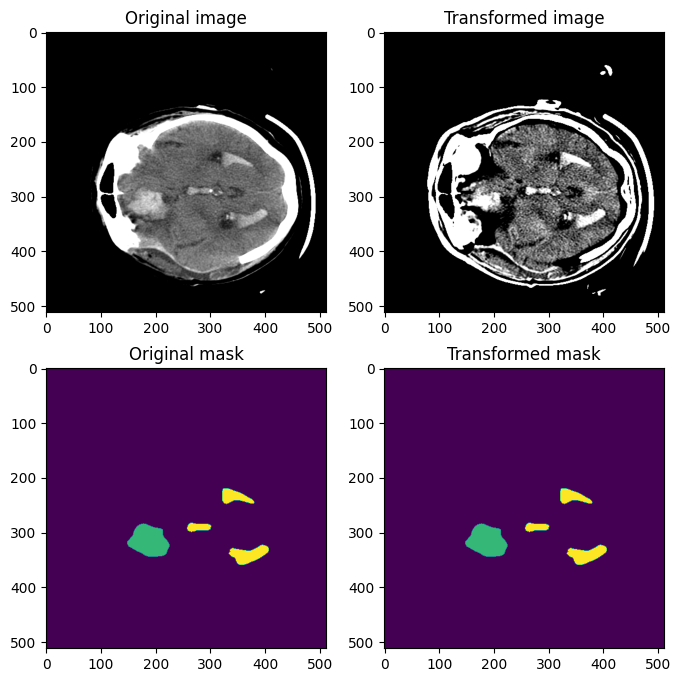

In [6]:
transform = transforms.RandGaussianSharpend(
    keys="image",
    sigma1_x=(0.25, 1.125),
    sigma1_y=(0.25, 1.25),
    sigma1_z=(0.25, 1.25),
    sigma2_x=0.2,
    sigma2_y=0.2,
    sigma2_z=0.2,
    approx="erf",
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandHistogramShift

`RandHistogramShiftd` 是 MONAI（Medical Open Network for AI）中的一种**字典版数据增强变换**，用于对图像执行随机直方图偏移（histogram shift）操作。这种增强技术可以模拟不同成像设备或患者之间的强度分布差异，从而提高模型的泛化能力。

### 使用场景 

- 适用于MRI、CT等医学图像，以增强对不同成像条件的鲁棒性。

### 参数解析 

| 参数名               | 类型                     | 说明                                                         |
| -------------------- | ------------------------ | ------------------------------------------------------------ |
| `keys`               | `list` / `tuple` / `str` | 要应用变换的数据键。详见 `monai.transforms.MapTransform`。   |
| `num_control_points` | `int` 或 `(int, int)`    | 控制点数量，决定非线性强度映射的形状。值越小，强度偏移越大。若为二元组，则从范围内随机选择。 |
| `prob`               | `float`                  | 应用直方图偏移的概率（范围：0 ~ 1）。                        |
| `allow_missing_keys` | `bool`                   | 如果某个键不存在，是否跳过而不报错。                         |

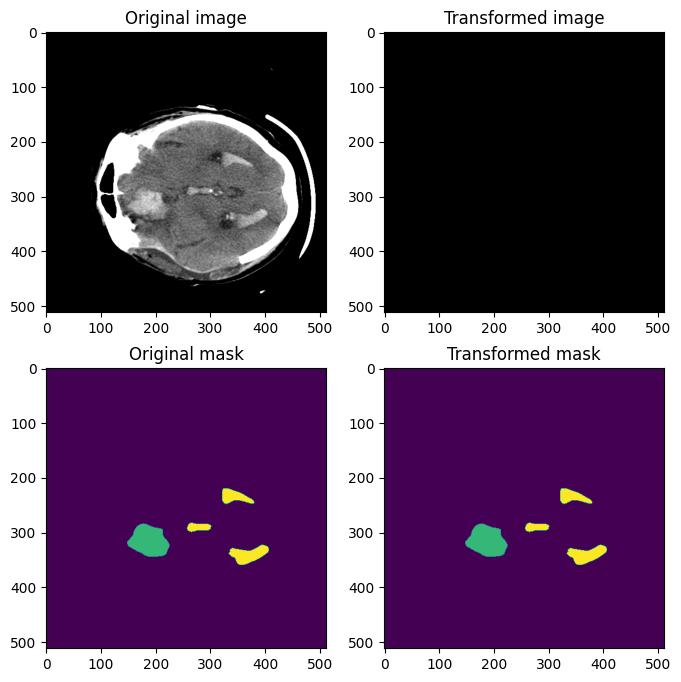

In [8]:
transform = transforms.RandHistogramShiftd(
    keys="image",
    num_control_points=3,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandGibbsNoise

`RandGibbsNoised` 是MONAI中实现的一种随机噪声增强方法，用来模拟图像中的**Gibbs噪声**。Gibbs噪声是一种常见的医学图像伪影（artifact），主要源于MRI扫描中的有限采样和重建过程，表现为图像边缘附近的波纹状噪声。通过添加Gibbs噪声，数据增强可以让模型更鲁棒，适应真实采集过程中可能出现的噪声，提升泛化能力。

`RandGibbsNoised`随机地将Gibbs噪声添加到输入图像中。它的实现核心是：

-   先将图像转换到频域（如通过FFT傅里叶变换）；

-   对频域数据进行部分去除/干扰，模拟采样不完全导致的频域信息缺失；

-   然后再转换回空间域，从而产生带有Gibbs伪影的图像。

### 使用场景 

-   MRI图像训练中，增强模型对Gibbs伪影的鲁棒性；

-   模拟实际扫描环境中的图像质量变化；

-   提升模型在真实环境中的泛化能力。

### 参数解析 

| 参数名               | 说明                                                         | 类型                       | 备注                                                         |
| -------------------- | ------------------------------------------------------------ | -------------------------- | ------------------------------------------------------------ |
| `keys`               | 需要被变换的数据键，如 `'image'`、`'label'` 或 `['image', 'label']` | str 或 list\[str\]         | 指定对哪些数据应用变换                                       |
| `prob`               | 应用该变换的概率                                             | float                      | 取值范围通常在0~1之间，表示概率                              |
| `alpha`              | 参数化Gibbs噪声滤波强度，取值区间为\[0,1\]                   | float 或 Sequence\[float\] | 如果是长度为2的列表如\[a,b\]，则alpha从区间\[a,b\]均匀采样；如果是float，则从\[0, alpha\]均匀采样。alpha=0时无变化（恒等映射） |
| `allow_missing_keys` | 若键不存在，是否允许不抛出异常                               | bool                       | 默认为False，设置为True时，缺失键不会抛异常                  |

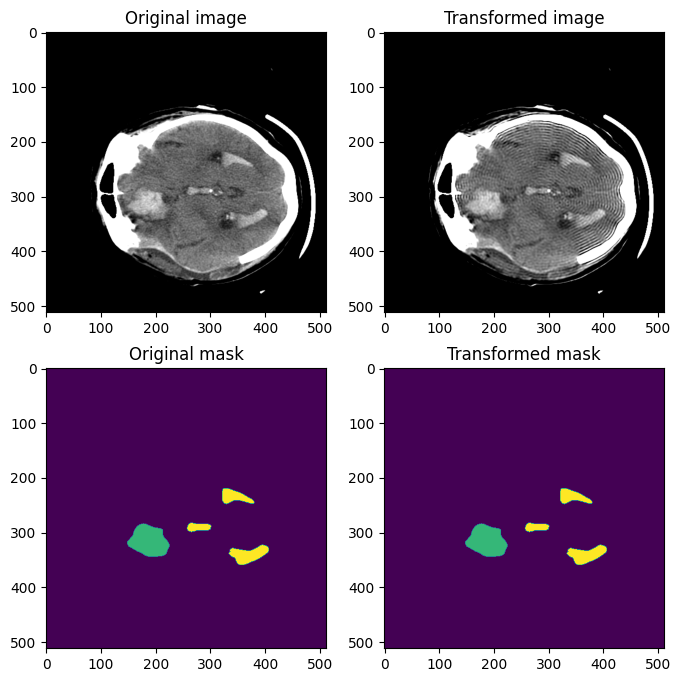

In [14]:
transform = transforms.RandGibbsNoised(
    keys="image",
    alpha=(0.6, 1),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandKSpaceSpikeNoise

`RandKSpaceSpikeNoised` 是 MONAI 中用于医学影像，特别是 MRI（磁共振成像）数据的一种随机噪声增强方式。它模拟 MRI 采集过程中可能出现的 **K 空间（频域）脉冲噪声（Spike Noise）**，目的是增强模型对这类噪声的鲁棒性。

MRI 图像是通过采集 K 空间（频域）数据，再做傅里叶逆变换获得空间域图像的。K 空间中的突发噪声会导致成像时出现条纹或光斑伪影。

### 使用场景 

- **MRI 图像数据增强**，特别是在训练深度学习模型时提高模型对实际仪器噪声的适应能力。
- **适合 MRI 图像**，对于其他成像方式不适用。
- **增大噪声幅度或脉冲数**会导致图像伪影更严重，可能降低图像质量。

### 参数解析 

| 参数名               | 说明                                                         | 类型               | 默认值            |
| -------------------- | ------------------------------------------------------------ | ------------------ | ----------------- |
| `keys`               | 需要进行变换的数据键名，如 `"image"`、`"label"` 或 `["image", "label"]` | str 或 list\[str\] | 必填              |
| `prob`               | 对字典中每个样本应用脉冲噪声的概率                           | float              | \-                |
| `intensity_range`    | 脉冲噪声的对数强度采样区间：<br/> \- 传入单个元组 `(a, b)`，对所有通道统一采样<br/> \- 传入多个元组 `((a0,b0), (a1,b1), ...)`，分别对每个通道采样，数量需与通道数匹配<br/> 默认取基于每个通道的平均对数强度的 `(0.95x, 1.10x)` | tuple 或 tuple序列 | `(0.95x, 1.10x)`  |
| `channel_wise`       | 是否对每个通道独立处理噪声                                   | bool               | True              |
| `allow_missing_keys` | 如果字典中缺失某个键，是否不抛出异常                         | bool               | False（通常默认） |

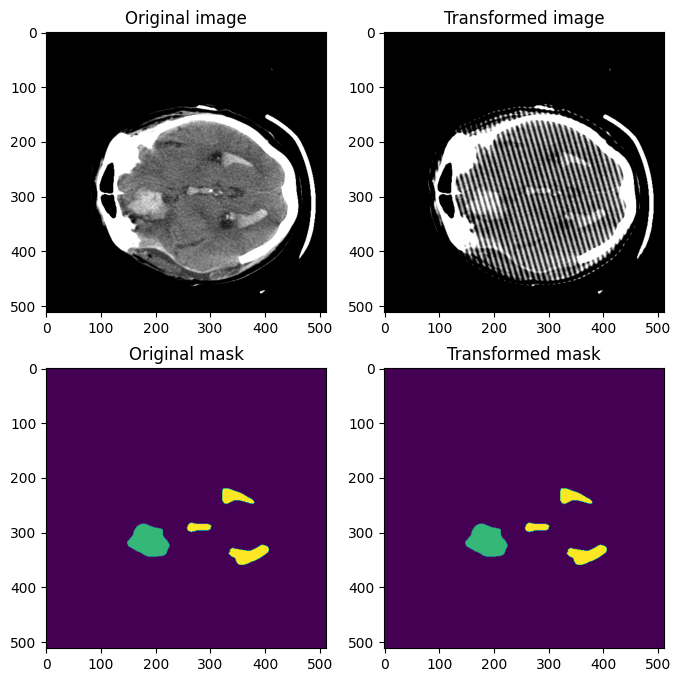

In [15]:
transform = transforms.RandKSpaceSpikeNoised(
    keys="image",
    intensity_range=(19, 20),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandCoarseDropout

`RandCoarseDropoutd` 是 MONAI 中用于医学图像数据增强的一个随机粗粒度遮挡（dropout）变换。它主要用于模拟图像中局部区域的缺失或遮挡，从而增强模型的鲁棒性，避免模型过度依赖某些局部特征。

这个变换会在输入的图像（或标签）张量上随机生成几个矩形区域，并将这些区域的像素值替换成指定的值（通常是0或者平均值）。这类似于经典的“Cutout”或“Coarse Dropout”技术，但应用于3D或多通道医学图像。

### 使用场景 

-   **鲁棒性增强**：模型不会过分依赖图像的某些局部区域，可以提升对遮挡、伪影的适应能力。

-   **模拟真实缺失**：在某些医学成像中可能会出现噪声、遮挡或扫描缺陷，`RandCoarseDropoutd`可以模拟这些场景。

-   **与其他增强联合**：通常和旋转、缩放、强度变换等结合使用，构建更丰富的数据增强流程。

### 参数解析 

| 参数名               | 类型                 | 说明                                                         | 默认值 |
| -------------------- | -------------------- | ------------------------------------------------------------ | ------ |
| `keys`               | list                 | 需要被变换的字段的键名，参考 `monai.transforms.compose.MapTransform` | 无     |
| `holes`              | int                  | 遮挡区域的数量。如果 `max_holes` 不为 None，则作为最小值，从最小到最大随机选择遮挡区域数。 | 无     |
| `spatial_size`       | tuple/list           | 遮挡区域的空间大小。如果 `max_spatial_size` 不为 None，则作为最小空间大小，从最小到最大随机选择每个区域大小。空间大小中非正值会被替换为输入图像对应维度大小。 | 无     |
| `dropout_holes`      | bool                 | 是否遮挡区域本身。True 表示遮挡区域填充 `fill_value`，False 表示遮挡区域保留，遮挡区域外部填充 `fill_value`。 | True   |
| `fill_value`         | int/float/tuple/None | 遮挡区域填充值。可为常数值，或 `(min, max)` 范围内随机取值，若为 None，则自动根据输入图像最小最大值随机选择填充。 | None   |
| `max_holes`          | int/None             | 遮挡区域数量最大值，若不为 None，则随机选取 `[holes, max_holes]` 区间的数量。 | None   |
| `max_spatial_size`   | tuple/list/None      | 遮挡区域空间大小最大值，若不为 None，则随机选取 `[spatial_size, max_spatial_size]` 区间大小。空间中非正值会替换为输入图像对应维度大小。 | None   |
| `prob`               | float                | 应用该变换的概率。                                           | 1.0    |
| `allow_missing_keys` | bool                 | 如果缺少指定的 key，是否不报错。                             | False  |

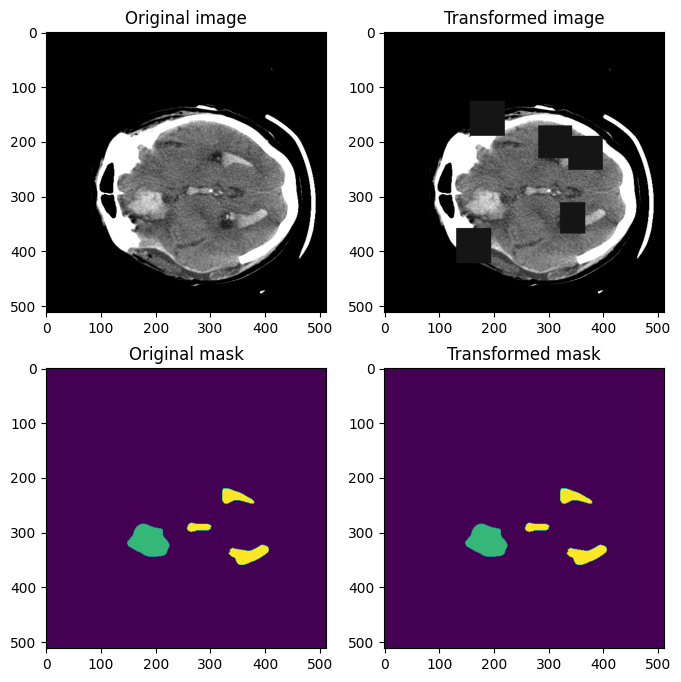

In [17]:
transform = transforms.RandCoarseDropoutd(
    keys="image",
    holes=2,
    spatial_size=38,
    fill_value=0,
    max_holes=5,
    max_spatial_size=64,
    prob=1
)
add_data_tmp = deepcopy(add_data)
aug_data = transform(add_data_tmp)
visualize(data, aug_data)

## RandCoarseShuffle

`RandCoarseShuffled` 是 MONAI 里一种随机粗粒度打乱的数据增强方式，主要用于增强图像的局部结构扰动，提升模型对局部变化的鲁棒性。

`RandCoarseShuffled` 是一种随机粗粒度的块状打乱增强方法。它的核心思想是：

-   将输入图像（或者多维医学图像）划分为多个粗粒度的块（block）。

-   在一定概率下，将这些块进行随机打乱（shuffle）。

-   打乱后的图像仍保持整体结构，但局部细节被扰动，从而让模型学习到更强的局部结构不变性。

### 使用场景 

-   医学3D图像训练时，增加数据多样性，防止模型过拟合。

-   需要模型对局部结构扰动鲁棒，如肿瘤检测、器官分割等。

### 参数解析 

| 参数名                   | 说明                                                         | 备注 / 举例                                                  |
| ------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ |
| **keys**                 | 需要被变换的数据键（通常是字典中的字段名），指明对哪些数据进行处理。 | 参见 `monai.transforms.compose.MapTransform`，通常是图像或标签的键，如 `["image", "label"]` |
| **holes**                | 需要“丢弃”或打乱的区域数量（最小值）。                       | 如果 `max_holes` 不为空，则在 `holes` 和 `max_holes` 范围内随机选择数量。 |
| **spatial\_size**        | 每个区域的空间尺寸（最小值），即单个“打乱块”或“丢弃块”的大小。 | 如果部分维度为负数或非正数，则取输入图像对应维度的大小。例如 `(32, -1)` 会变成 `(32, 输入维度大小)` |
| **max\_holes**           | 最大的区域数量。                                             | 用于和 `holes` 一起随机确定“打乱”区域的数量。                |
| **max\_spatial\_size**   | 最大的空间尺寸。                                             | 用于和 `spatial_size` 一起随机确定“打乱块”的大小，规则同上。 |
| **prob**                 | 应用该变换的概率。                                           | 取值范围 0~1，控制是否对当前数据应用该增强。                 |
| **allow\_missing\_keys** | 如果目标数据键缺失，是否忽略而不报错。                       | True 时缺少 keys 不报错，False 时缺少时会抛异常。            |

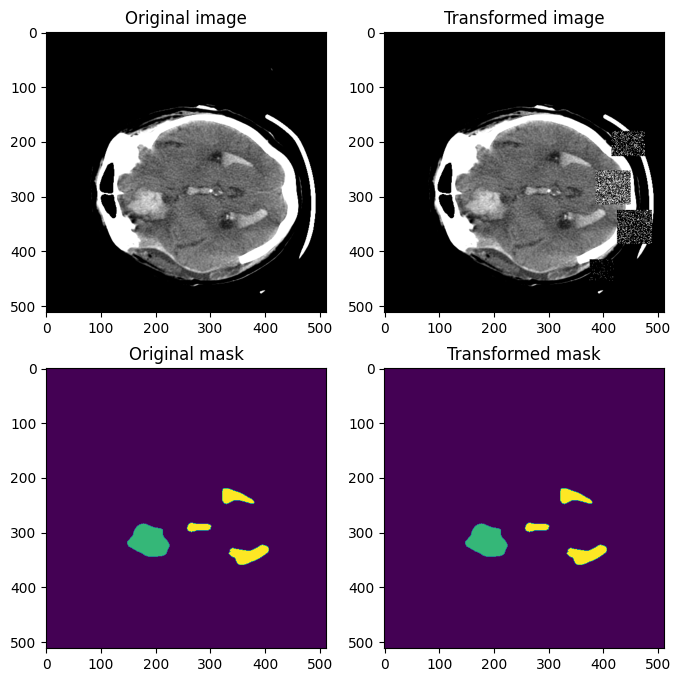

In [20]:
transform = transforms.RandCoarseShuffled(
    keys="image",
    holes=4,
    spatial_size=38,
    max_holes=6,
    max_spatial_size=64,
    prob=1
)
add_data_tmp = deepcopy(add_data)
aug_data = transform(add_data_tmp)
visualize(data, aug_data)

## HistogramNormalize

`HistogramNormalized` 通过直方图匹配来标准化图像的强度分布，使图像的灰度值更一致，减小不同扫描仪、不同患者间的强度差异，提升模型的鲁棒性。

`HistogramNormalized` 的核心思想是：

-   **参考图像**（reference image）提供一个灰度直方图的参考模板。

-   对输入图像计算灰度直方图，然后将其调整，使得输入图像的直方图“匹配”参考图像的直方图。

-   这样，输入图像的像素值分布被映射到参考图像的分布，实现强度归一化。

### 使用场景 

-   多中心数据，扫描设备不统一。

-   不同病人或不同扫描序列图像灰度值差异大。

-   训练前统一数据强度分布，提高模型泛化能力。

### 参数解析 

| 参数名               | 类型                  | 默认值  | 说明                                                         |
| -------------------- | --------------------- | ------- | ------------------------------------------------------------ |
| `keys`               | list of str           | 必填    | 需要进行变换的键，对应输入数据中的字段。参考 `MapTransform`。 |
| `num_bins`           | int                   | 256     | 用于直方图的bin数量，参考 [numpy.histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)。 |
| `min`                | int/float             | 255     | 归一化时输入图像的最小值。                                   |
| `max`                | int/float             | 255     | 归一化时输入图像的最大值。                                   |
| `mask`               | ndarray (bool or 0/1) | None    | 可选，形状与图像相同的掩码，仅对 `mask==True` 的点做直方图均衡。 |
| `mask_key`           | str                   | None    | 如果 `mask` 未提供，运行时尝试通过 `mask_key` 获取掩码。     |
| `dtype`              | 数据类型              | float32 | 输出数据类型，若为None则和输入图像数据类型相同。             |
| `allow_missing_keys` | bool                  | False   | 如果指定的键缺失，是否跳过不报错。                           |

image mean: 159.7866973876953, image std: 51.98253631591797


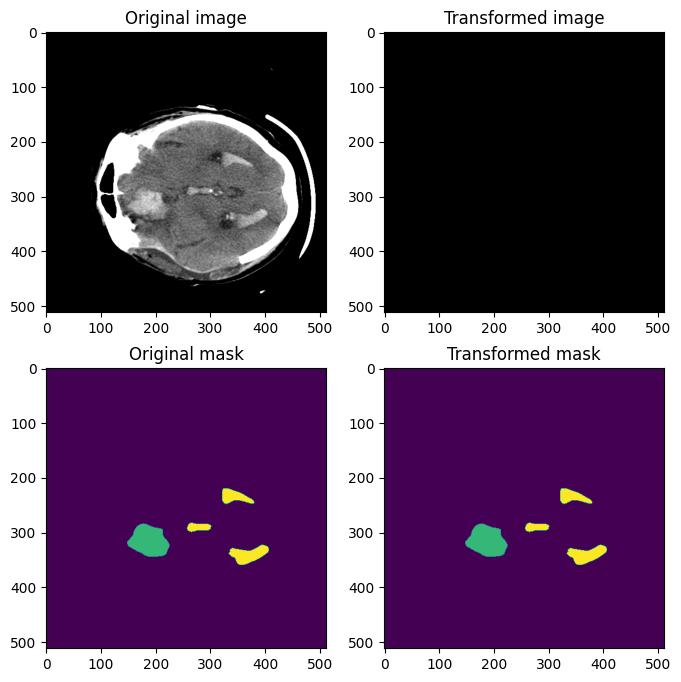

In [21]:
transform = transforms.HistogramNormalized(
    keys="image",
    min=0,
    max=255,
)
aug_data = transform(add_data)
print(f"image mean: {aug_data['image'].mean()}, image std: {aug_data['image'].std()}")
visualize(data, aug_data)

## ForegroundMask

`ForegroundMaskd` 主要用来基于输入图像的“前景”生成掩码（mask）。“前景”通常指的是图像中非背景的部分，比如医学影像中的组织或病灶区域。这个转换非常适合做基于前景区域的图像增强、裁剪、采样等操作。

它会根据输入的图像自动识别“前景”区域（通常是非零像素或满足一定条件的像素），生成一个二值掩码，标记出前景区域。

### 使用场景 

-   生成前景掩码，帮助后续的数据增强只针对前景区域生效，比如只对病灶区域做随机旋转、裁剪。

-   在训练时，结合前景掩码，进行前景优先采样。

-   可以用来减少背景噪声对模型训练的影响。

### 参数解析 

| 参数名               | 类型                                | 说明                                                         | 备注                                                         |
| -------------------- | ----------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| `keys`               | str 或 list                         | 需要转换的字典中的键名（对应需要生成前景掩码的图像数据）。   |                                                              |
| `threshold`          | int / float / callable / str / dict | 用来定义前景的阈值。阈值以下的像素视为前景。<br/> \- 可以是固定数值<br/> \- 可以是一个函数（接收图像每个维度计算阈值）<br/> \- 也可以是字符串，指明使用 `skimage.filters` 中的阈值函数<br/> \- 也可以是字典，为每个通道指定不同阈值（例如 {"R":100, "G":"otsu", "B": skimage.filter.threshold_mean}） | 字符串对应的函数需要参考 [skimage.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) |
| `hsv_threshold`      | int / float / callable / str        | 类似 `threshold`，但是是在 HSV 色彩空间中使用。<br/>在 HSV 空间中，像素值大于阈值才被认为是前景。 | 适用于彩色图像，基于色调、饱和度、明度判断前景。             |
| `invert`             | bool                                | 是否反转输入图像的像素强度范围，即将 dtype 最大值变成最小值，最小值变成最大值。 | 用于调整对前景的判定逻辑。                                   |
| `new_key_prefix`     | str                                 | 输出生成的掩码对应的键名前缀。若设置，则新掩码会以 `new_key_prefix + 原key` 的形式保存，原图像对应的值保持不变。默认不设置，直接替换原 key 对应的值。 | 方便保留原始图像数据。                                       |
| `allow_missing_keys` | bool                                | 如果输入字典中缺少指定的 key，是否跳过而不抛出异常。         | 默认为 False，缺失会报错。                                   |

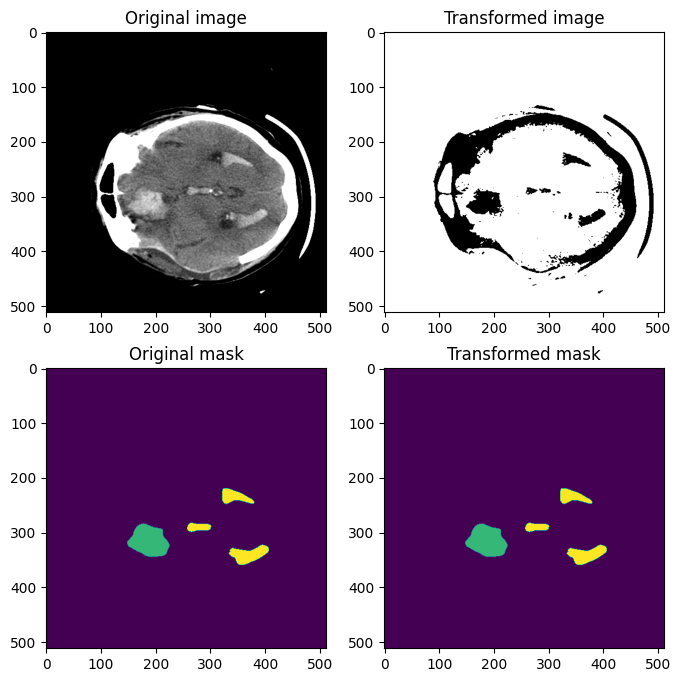

In [23]:
transform = transforms.ForegroundMaskd(
    keys="image",
    threshold=40,
)
aug_data = transform(add_data)
visualize(data, aug_data)